# Common

### Imports

In [529]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Config

In [530]:
BATCH_SIZE = 256
EPOCH_COUNT = 1

torch.manual_seed(420)

CLASS_COUNT = 10 # One for each digit
PARAMS_PER_PRED = 5 + CLASS_COUNT # confidence, x, y, width, height, class probabilities

CONFIDENCE_THRESHOLD = 0.5
ACCURACY_WEIGHT = 0.5
IOU_WEIGHT = 1 - ACCURACY_WEIGHT


### Utilities

In [531]:
def load_dataset(name:str):
    train = torch.load(f'data/{name}_train.pt')
    val = torch.load(f'data/{name}_val.pt')
    test = torch.load(f'data/{name}_test.pt')

    print(f"Dataset '{name}'")
    print(f"Training size:   {len(train)}")
    print(f"Validation size: {len(val)}")
    print(f"Test size:       {len(test)}")

    train = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

    return train, val, test

def split_label(label_tensor):
    confidence = label_tensor[:, 0:1]
    box = label_tensor[:, 1:5]
    classes = label_tensor[:, 5:]

    return confidence, box, classes

def get_iou(box1:[float], box2:[float]):
    X, Y, W, H = 0, 1, 2, 3

    # Calculate area of intersection rectangle
    intersection_width = min(box1[X] + box1[W], box2[X] + box2[W]) - max(box1[X], box2[X])
    intersection_height = min(box1[Y] + box1[H], box2[Y] + box2[H]) - max(box1[Y], box2[Y])
    intersection_area = intersection_width * intersection_height

    # Calculate areas of both boxes
    box1_area = box1[W] * box1[H]
    box2_area = box2[W] * box2[H]

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    if union_area < 0:
        return 0

    # Calculate IoU
    return intersection_area / union_area

def draw_image(image:torch.Tensor, boxes:[(float, float, float, float, str)]):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))

    _, height, width = image.shape

    for box in boxes:
        x, y, w, h, label = box

        # Scale to image
        x *= width * 0.5
        y *= height * 0.5
        w *= width
        h *= height

        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, label, color='r')

    plt.show()
    

In [532]:
def train(model, dataset, loss_fn):
    model.train() # Set model to training mode

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(EPOCH_COUNT):
        aggregate_loss = 0.0

        for X, Y_true in dataset:
            optimizer.zero_grad()

            Y_pred = model(X)
            
            loss = loss_fn(Y_true, Y_pred)

            loss.backward()

            optimizer.step()

            aggregate_loss += loss.item()

        print(f"Epoch {epoch+1}/{EPOCH_COUNT} - Loss: {aggregate_loss}")

In [533]:
def validate(model, dataset, performance_fn):
    model.eval() # Set model to evaluation mode

    with torch.no_grad():

        total_count = 0
        correct_count = 0
        aggregate_iou = 0.0

        for x, y_true in dataset:

            correct, iou = performance_fn(y_true, model(x))

            total_count   += 1
            correct_count += correct
            aggregate_iou += iou

        accuracy = correct_count / total_count
        iou      = aggregate_iou / total_count
        performance = (accuracy * ACCURACY_WEIGHT) + (iou * IOU_WEIGHT)

        print(f"Validation - Accuracy: {accuracy}, IoU: {iou}, Performance: {performance}")

In [534]:
def train_or_load(model, loss_fn, name:str):
    try:
        model.load_state_dict(torch.load(f'models/{name}.pt'))
        print(f"Model '{name}' loaded from file")
    except:
        print(f"Model '{name}' not found, training new model")
        train(model, loss_fn)
        torch.save(model.state_dict(), f'models/{name}.pt')

# Object localization
Localize and classify images of digits.
- Image dimensions are `height=48`, `wight=60` and `channels=1`
- Each image contains exactly **one** digit

## Load localization datasets

In [535]:
loc_train, loc_val, loc_test = load_dataset('localization')

Dataset 'localization'
Training size:   59400
Validation size: 6600
Test size:       11000


## Define networks

In [536]:
class CnnV1(nn.Module):
    """
    Expected input image to be 48x60x3.
    """

    def __init__(self):
        super(CnnV1, self).__init__()
        
        # Data = 48x60x3

        self.l1_conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.l2_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Data = 24x30x10

        self.l3_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.l4_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Data = 12x15x10

        self.l5_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.l6_pool = nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)

        # Data = 6x5x10

        self.l7_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
        
        # Data = 6x5x10

        self.l8_fc = nn.Linear(in_features=6*5*10, out_features=100)
        self.l9_fc = nn.Linear(in_features=100, out_features=PARAMS_PER_PRED)

    def forward(self, x:torch.Tensor) -> torch.Tensor:

        x = torch.relu(self.l1_conv(x))
        x = self.l2_pool(x)

        x = torch.relu(self.l3_conv(x))
        x = self.l4_pool(x)

        x = torch.relu(self.l5_conv(x))
        x = self.l6_pool(x)

        x = torch.relu(self.l7_conv(x))

        x = x.view(-1, 6*5*10)

        x = torch.relu(self.l8_fc(x))

        x = torch.relu(self.l9_fc(x))

        return x

In [537]:
class CnnV2(nn.Module):
    """
    Expected input image to be 48x60x3.
    """

    def __init__(self):
        super(CnnV2, self).__init__()
        
        # Data = 48x60x3

        self.l1_conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=9, stride=1, padding=0)

        # Data = 40x52x10
        
        self.l2_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=7, stride=1, padding=0)

        # Data = 34x46x10
        
        self.l3_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=7, stride=1, padding=0)

        # Data = 28x40x10
        
        self.l4_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Data = 24x36x10

        self.l5_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Data = 12x18x10

        self.l6_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Data = 8x14x10

        self.l7_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Data = 4x10x10

        self.l8_fc = nn.Linear(in_features=4*10*10, out_features=100)
        self.l9_fc = nn.Linear(in_features=100, out_features=50)
        self.l10_fc = nn.Linear(in_features=50, out_features=PARAMS_PER_PRED)


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.l1_conv(x))
        x = torch.relu(self.l2_conv(x))
        x = torch.relu(self.l3_conv(x))
        x = torch.relu(self.l4_conv(x))
        x = self.l5_pool(x)
        x = torch.relu(self.l6_conv(x))
        x = torch.relu(self.l7_conv(x))

        x = x.view(-1, 4*10*10)

        x = torch.relu(self.l8_fc(x))
        x = torch.relu(self.l9_fc(x))
        x = torch.relu(self.l10_fc(x))

        return x

## Define training

In [538]:
loss_fn_confidence = nn.BCEWithLogitsLoss()
loss_fn_class = nn.CrossEntropyLoss()
loss_fn_box = nn.MSELoss()

def loss_fn(y_true, y_pred):

    # Used to filter out prodictions without objects
    has_object_mask = y_true[:, 0] >= CONFIDENCE_THRESHOLD

    # Extract true values
    y_true_confidence, y_true_box, y_true_classes = split_label(y_true)

    # Convert class labels to one-hot
    y_true_classes = torch.nn.functional.one_hot(y_true_classes.long(), num_classes=CLASS_COUNT).float().squeeze()
    
    # Extract predicted values
    y_pred_confidence, y_pred_box, y_pred_classes = split_label(y_pred)

    # Calculate confidence loss for all labels
    confidence_loss = loss_fn_confidence(y_pred_confidence, y_true_confidence)

    # Calculate box and class loss for labels with objects
    box_loss = loss_fn_box(y_pred_box[has_object_mask], y_true_box[has_object_mask])
    class_loss = loss_fn_class(y_pred_classes[has_object_mask], y_true_classes[has_object_mask])

    # Return sum of all losses
    return confidence_loss + box_loss + class_loss

In [539]:
def performance_fn(y_true, y_pred) -> (int, float):

    # Extract true values
    y_true_confidence = y_true[0:1].item()
    y_true_box = y_true[1:5].tolist()
    y_true_class = y_true[5:].long().item()

    # Extract predicted values
    y_pred_confidence = torch.sigmoid(y_pred[0, 0:1]).item()
    y_pred_box = y_pred[0, 1:5].tolist()
    y_pred_class = y_pred[0, 5:].argmax(dim=-1).tolist()

    # Check if the label contains an object
    no_object = y_true_confidence < CONFIDENCE_THRESHOLD
    predicted_no_object = y_pred_confidence < CONFIDENCE_THRESHOLD

    # If we correctly predict no object, we don't care about the other values
    if no_object and predicted_no_object:
        return 1, 1.0

    if no_object:
        return 0, 0.0

    iou = get_iou(y_true_box, y_pred_box)

    if y_true_class == y_pred_class:
        return 1, iou
    return 0, iou

### Train models

Epoch 1/1 - Loss: 1173.3659927845001
Validation - Accuracy: 0.08757575757575757, IoU: -0.11713622902828764, Performance: -0.014780235726265037


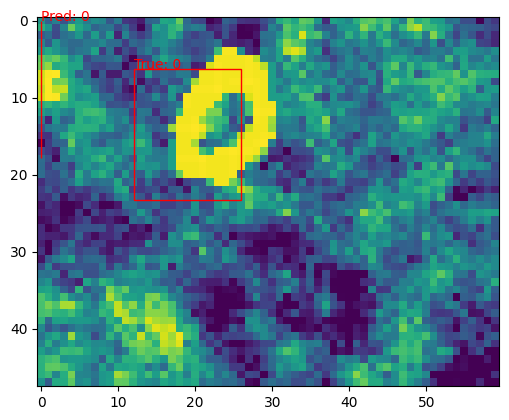

In [540]:
cnnv2_1 = CnnV2()

train(cnnv2_1, loc_train, loss_fn)
validate(cnnv2_1, loc_val, performance_fn)

def print_prediction_sample(model, dataset, sample_index):
    model.eval()
    image, y_true = dataset[sample_index]
    with torch.no_grad():    
        # Extract true values
        y_true_confidence = y_true[0:1].item()
        y_true_box = y_true[1:5].tolist()
        y_true_class = y_true[5:].long().item()

        # Extract predicted values
        y_pred_confidence = torch.sigmoid(y_pred[0, 0:1]).item()
        y_pred_box = y_pred[0, 1:5].tolist()
        y_pred_class = y_pred[0, 5:].argmax(dim=-1).tolist()

        draw_image(image, [
            (y_true_box[0], y_true_box[1], y_true_box[2], y_true_box[3], f"True: {y_true_class}"), 
            (y_pred_box[0], y_pred_box[1], y_pred_box[2], y_pred_box[3], f"Pred: {y_pred_class}")
        ])

print_prediction_sample(cnnv1_1, loc_val, 132)